In [1]:
import pandas as pd
import numpy as np
from numpy import array
import xml.etree.ElementTree as ET
import string

import re
#NLTK
import nltk
from nltk import word_tokenize, WordPunctTokenizer, regexp_tokenize
from nltk import word_tokenize, WordPunctTokenizer, regexp_tokenize
from nltk.corpus import stopwords
#Plotting 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


# Data de entrenamiento

In [2]:
tree = ET.parse('train.xml')
root = tree.getroot()

In [3]:
train_set = pd.DataFrame({'tweet_id':[],'tweetText':[],'polarity_value':[],'polarity_type':[],'topic':[]})
row=0
for tweet in root:
    tweet_id = 'ID:'+tweet.find('tweetid').text
    tweetText = tweet.find('content').text
    lang = tweet.find('lang').text
    polarity_value = tweet.find('sentiments').find('polarity').find('value').text
    polarity_type = tweet.find('sentiments').find('polarity').find('type').text
    topic = tweet.find('topics').find('topic').text
    
    if lang == 'es':
        train_set.loc[row] = [tweet_id,tweetText,polarity_value,polarity_type,topic]
        row+=1

In [4]:
train_set['set']='train'

In [5]:
#Mostrando la data
train_set.head(10)

,tweet_id,tweetText,polarity_value,polarity_type,topic,set
0,ID:142389495503925248,"Salgo de #VeoTV , que día más largoooooo...",NONE,AGREEMENT,otros,train
1,ID:142389933619945473,@PauladeLasHeras No te libraras de ayudar me/n...,NEU,DISAGREEMENT,otros,train
2,ID:142391947707940864,@marodriguezb Gracias MAR,P,AGREEMENT,otros,train
3,ID:142416095012339712,"Off pensando en el regalito Sinde, la que se v...",N,AGREEMENT,política,train
4,ID:142422495721562112,Conozco a alguien q es adicto al drama! Ja ja ...,P,AGREEMENT,otros,train
5,ID:142424715175280640,"RT @FabHddzC: Si amas a alguien, déjalo libre....",NONE,AGREEMENT,música,train
6,ID:142483342040907776,Toca @crackoviadeTV3 . Grabación dl especial N...,P,AGREEMENT,entretenimiento,train
7,ID:142493511634259968,Hoy asisitiré en Madrid a un seminario sobre l...,NONE,AGREEMENT,política,train
8,ID:142494476051562496,Buen día todos! Lo primero mandar un abrazo gr...,P,AGREEMENT,otros,train
9,ID:142496796416016384,Desde el escaño. Todo listo para empezar #endi...,P,AGREEMENT,política,train


In [6]:
train_set.columns = ['tweet_id', 'tweetText', 'polarity_value', 'polarity_type', 'topic','set']

In [7]:
train_set.head(4)

,tweet_id,tweetText,polarity_value,polarity_type,topic,set
0,ID:142389495503925248,"Salgo de #VeoTV , que día más largoooooo...",NONE,AGREEMENT,otros,train
1,ID:142389933619945473,@PauladeLasHeras No te libraras de ayudar me/n...,NEU,DISAGREEMENT,otros,train
2,ID:142391947707940864,@marodriguezb Gracias MAR,P,AGREEMENT,otros,train
3,ID:142416095012339712,"Off pensando en el regalito Sinde, la que se v...",N,AGREEMENT,política,train


In [8]:
train_set.topic.value_counts()

política           2715
otros              1620
entretenimiento    1209
economía            525
música              412
fútbol              225
cine                183
tecnología          144
deportes            101
literatura           84
Name: topic, dtype: int64

In [9]:
train_set.polarity_value.value_counts()

P       2884
N       2182
NONE    1482
NEU      670
Name: polarity_value, dtype: int64

In [10]:
train_set = train_set.loc[(train_set.polarity_value == 'P') | (train_set.polarity_value == 'N') ]

# Tweets Peruanos 

In [11]:
tweets=pd.read_json('data.json',lines=True)
tweets['set']='test'
tweets['polarity_value']=np.NaN


In [12]:
#Dimensiones
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype                                 
---  ------           --------------  -----                                 
 0   id               5000 non-null   int64                                 
 1   conversation_id  5000 non-null   int64                                 
 2   created_at       5000 non-null   datetime64[ns, pytz.FixedOffset(-300)]
 3   date             5000 non-null   datetime64[ns]                        
 4   time             5000 non-null   object                                
 5   timezone         5000 non-null   int64                                 
 6   user_id          5000 non-null   int64                                 
 7   username         5000 non-null   object                                
 8   name             5000 non-null   object                                
 9   place            5000 non-null   object  

# Procesando Tweets

In [13]:
processed_tweets= pd.concat([pd.DataFrame({'tweetID':tweets.id, 'tweetText':tweets.tweet,'polarity_value':tweets.polarity_value, 'set':tweets.set}), 
                             pd.DataFrame({'tweetID':train_set.tweet_id, 'tweetText':train_set.tweetText, 'polarity_value':train_set.polarity_value,'set':train_set.set})], ignore_index=True)
processed_tweets['processed_tweet'] = processed_tweets.tweetText
processed_tweets.sample(4)

,tweetID,tweetText,polarity_value,set,processed_tweet
4569,1327725400445874176,@PoliciaPeru Aun estan a tiempo de no embarrar...,NaN,test,@PoliciaPeru Aun estan a tiempo de no embarrar...
1280,1327753314520412160,Merino No es mi Presidente #Peru Raus Merino ...,NaN,test,Merino No es mi Presidente #Peru Raus Merino ...
3240,1327737128181182466,Sexto día consecutivo de protestas. Merino hue...,NaN,test,Sexto día consecutivo de protestas. Merino hue...
69,1327762687321894912,Es el miedo a la presión popular que hace saca...,NaN,test,Es el miedo a la presión popular que hace saca...


## Hashtags

In [14]:

hash_regex = re.compile(r"#(\w+)")
hstgs = [] # Para almacenar los hashtags para que podamos excluirlos de algunas partes del análisis.
def hash_repl(match):
    _ = '__HASH_'+match.group(1).upper()
    hstgs.append(_)
    return _

## USERNAMES

In [15]:
user_regex = re.compile(r"@(\w+)")
usr_names = [] #Para almacenar los nombres de usuario para que podamos excluirlos de algunas partes del análisis
def user_repl(match):
    _ = '__user_'+match.group(1).upper()
    usr_names.append(_)
    return _

## URLs

In [16]:
url_regex = re.compile(r"(http|https|ftp)://[a-zA-Z0-9\./]+")
def url_repl(match):
    return '__URL_'


## REPETI

In [17]:
rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE);
def rpt_repl(match):
    return match.group(1)+match.group(1)

In [18]:
# Test
re.sub(rpt_regex, rpt_repl, "Repppppppetirrrrrr" )

'Reppetirr'

## Puntuacion

In [19]:
# División por límites de palabras
word_bound_regex = re.compile(r"\W+")

# Puntuacion
punctuations = \
	[	#('',		['.', ] )	,\
		#('',		[',', ] )	,\
		#('',		['\'', '\"', ] )	,\
		('__PUNC_EXCL',		['!', '¡', ] )	,\
		('__PUNC_QUES',		['?', '¿', ] )	,\
		('__PUNC_ELLP',		['...', '…', ] )	,\
	]

#Para reemplazar la puntuación
def punctuations_repl(match):
	text = match.group(0)
	repl = []
	for (key, parr) in punctuations :
		for punc in parr :
			if punc in text:
				repl.append(key)
	if( len(repl)>0 ) :
		return ' '+' '.join(repl)+' '
	else :
		return ' '

## Stemming

In [20]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [21]:
# Test
text = processed_tweets.processed_tweet[55]
print(text)
text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if ((len(word) >= 3) and (word not in usr_names))]
text = [stemmer.stem(w) for w in text]                
text = " ".join(text)
print('------------------')
print(text)

@AlertaNews24 Oeee jajajajajaa pobre la mamá de merino csmre jajajajajaa que se largue esa rataaaa
------------------
@alertanews24 oeee jajajajaja pobr mam merin csmre jajajajaja que larg esa rataaa


In [22]:
def sb_stem(text, only_first=0):
    text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if ((len(word) >= 3) or (word in ['no','si', 'sí', 'ni']))] #   If we are doing negation analysis, maybe is a better idea to keep the small words (like 'no')
    text = [stemmer.stem(w) if w[0:2]!='__' else w for w in text ]
    
    return(text)

In [23]:

def processAll(text):
    text = re.sub( hash_regex, hash_repl, text )
    text = re.sub( user_regex, user_repl, text)
    text = re.sub( url_regex, url_repl, text )
    
    text = text.replace('\'','')
    
    text = re.sub( word_bound_regex , punctuations_repl, text )
    text = re.sub( rpt_regex, rpt_repl, text )
    
    text = sb_stem(text)    
    return text

In [24]:
d="Aasda!.? @Hola #Aea https://facebo.com asd"
processAll(d)

['aasd',
 '__PUNC_EXCL',
 '__PUNC_QUES',
 '__user_HOLA',
 '__HASH_AEA',
 '__URL_',
 'asd']

# Procesamiento de tweets

In [25]:
processed_tweets['processed_tweet'] = processed_tweets.tweetText.apply(processAll)


In [26]:
processed_tweets.sample(4)

,tweetID,tweetText,polarity_value,set,processed_tweet
4792,1327723314861776898,Firme y feliz por la unión... contra Merino.,NaN,test,"[firm, feliz, por, union, __PUNC_ELLP, contr, ..."
2268,1327745516944437249,@merino_monroy @FUERZARMADASV @nayibbukele @Ej...,NaN,test,"[__user_MERINO_MONROY, __user_FUERZARMADASV, _..."
2699,1327742029158289409,@Capacapo3 @carolineweisss @BCPGianfranco No t...,NaN,test,"[__user_CAPACAPO3, __user_CAROLINEWEISS, __use..."
9046,ID:179537060917547009,Dice q @sorayapsoe es necesario flexibilizar c...,N,train,"[dic, __user_SORAYAPSOE, necesari, flexibiliz,..."


## Funciones

### Emoticones

In [27]:
emoticons = \
	[	# For __EMOT_SMILEY
        (' __emoji: U+1F601',	[':-)', ':)', '(:', '(-:', ] )	,\
        # for __EMOT_LAUGH
		(' __emoji: U+1F923',		[':-D', ':D', 'X-D', 'XD', 'xD', ] )	,\
        # For __EMOT_LOVE
		(' __emoji: U+2764',		['<3', ':\*', ] )	,\
        # For __EMOT_WINK
		('__emoji: U+1F609',		[';-)', ';)', ';-D', ';D', '(;', '(-;', ] )	,\
        # For __EMOT_FROWN
		(' __emoji: U+2639',		[':-(', ':(', '(:', '(-:', ] )	,\
        # For __EMOT_CRY
		(' __emoji: U+1F622',		[':,(', ':\'(', ':"(', ':(('] )	,\
	]
    
def escape_paren(arr):
	return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]

def regex_union(arr):
	return '(' + '|'.join( arr ) + ')'

emoticons_regex = [ (repl, re.compile(regex_union(escape_paren(regx))) ) for (repl, regx) in emoticons ]

In [28]:
# Test
text = "This is a text with one emoticon :) and another :("
for (repl, regx) in emoticons_regex :
    text = re.sub(regx, ' '+repl+' ', text)
    
print(text)

This is a text with one emoticon   __emoji: U+1F601  and another   __emoji: U+2639 


In [29]:
emojis_db=pd.read_csv('emojis_db_csv.csv')
emojis_db.head()

,emoji_category,number,code,CLDR_Short_Name
0,face-positive,1,U+1F600,grinning face
1,face-positive,2,U+1F601,beaming face with smiling eyes
2,face-positive,3,U+1F602,face with tears of joy
3,face-positive,4,U+1F923,rolling on the floor laughing
4,face-positive,5,U+1F603,grinning face with big eyes


In [30]:
def emojis_unicode(tweet):
    ''' Extracts the emojis on the tweet on Unicode format, also tries to match those in regular format, such as ";)" '''
    for (repl, regx) in emoticons_regex :
        tweet = re.sub(regx, ' '+repl+' ', tweet)
#     print(tweet)

    tweet_unicode = str(tweet.encode('unicode-escape'))
    tweet_unicode = tweet_unicode.replace('\\\\U000',' __emoji: U+')
#     print(tweet_unicode)
    
    emoji_list = []
#     print(tweet)
    for emoji in range(tweet_unicode.count(' __emoji: ')):
        em = tweet_unicode.split('__emoji: ')[emoji+1].split()[0]
        em = em[:7] # the len of the emoji in unicode is between 6 and 7
        emoji_list.append(em.upper())
    return emoji_list

In [31]:
# Test
text = "😡🤣😂"
emojis_unicode(text)

['U+1F621', 'U+1F923', 'U+1F602']

In [32]:
def emoji_category(emojis):
    categories = []
    for i in range(len(emojis)):
        # print(emojis[i])
        try:
            categories.append(emojis_db.loc[emojis_db.code == emojis[i]].emoji_category.values[0])
        except:
            try:
                _ = emojis[i].split('+')[1] + '+'
                categories.append(emojis_db[emojis_db.code.str.contains(_)].emoji_category.values[0])
            except:
                categories.append('other')
    if len(categories) < 1:
        categories.append('no_emojis')
    return categories

emoji_category(emojis_unicode(text))

['face-negative', 'face-positive', 'face-positive']

In [33]:

# Wrapper function that encloses all the n-grams procedures
def get_word_features(words):
    bag = {}
    words_uni = [ 'has(%s)'% ug for ug in words ]
    words_bi  = [ 'has(%s)'% ','.join(map(str,bg)) for bg in nltk.bigrams(words) ]
    words_tri = [ 'has(%s)'% ','.join(map(str,tg)) for tg in nltk.trigrams(words) ]
    
    for f in words_uni+words_bi+words_tri:
        bag[f] = 1

    return bag

### Negacion

In [34]:
negtn_regex = re.compile( r"""(?:
    ^(?:nunca|no|nada|ningún|ninguno|ninguna|tampoco|
        nunc|nad|ningun|tampoc
    )$
)
|
n't
""", re.X)

def get_negation_features(words):
    INF = 0.0
    negtn = [ bool(negtn_regex.search(w)) for w in words ]

    left = [0.0] * len(words)
    prev = 0.0
    for i in range(0,len(words)):
        if( negtn[i] ):
            prev = 1.0
        left[i] = prev
        prev = max( 0.0, prev-0.1)

    right = [0.0] * len(words)
    prev = 0.0
    for i in reversed(range(0,len(words))):
        if( negtn[i] ):
            prev = 1.0
        right[i] = prev
        prev = max( 0.0, prev-0.1)

    return dict( zip(
                    ['neg_l('+w+')' for w in  words] + ['neg_r('+w+')' for w in  words],
                    left + right ) )

In [35]:
# Test
text = ["Este","tweet", "no", "es", "positivo"]
get_negation_features(text)


{'neg_l(Este)': 0.0,
 'neg_l(tweet)': 0.0,
 'neg_l(no)': 1.0,
 'neg_l(es)': 0.9,
 'neg_l(positivo)': 0.8,
 'neg_r(Este)': 0.8,
 'neg_r(tweet)': 0.9,
 'neg_r(no)': 1.0,
 'neg_r(es)': 0.0,
 'neg_r(positivo)': 0.0}

### Polarity


Intentamos utilizar el léxico del sentimiento en español de http://www.opener-project.eu/ pero no mejoró los resultados en ninguno de los algoritmos. Tal vez por el hecho de que el español de España es diferente al español que se habla en Sudamerica.

In [36]:
opener_lexicon = pd.read_csv('https://raw.githubusercontent.com/opener-project/public-sentiment-lexicons/master/propagation_lexicons/es/es.lemma.sy.an.hypo.rels.maxdepth5.seed500.maj.gold.csv', sep=';', header=None)
opener_lexicon.columns = ['x','pos', 'polarity', 'xx','word','xxx']
opener_lexicon.head()

,x,pos,polarity,xx,word,xxx
0,unknown,n,positive,1.0,felicitación,1
1,unknown,a,negative,1.0,inconsciente,1
2,unknown,n,neutral,1.0,soporte,1
3,unknown,n,neutral,1.0,proceso_matemático,1
4,unknown,v,positive,1.0,manifestar,1


In [37]:
def get_sent(polarity):
    if polarity == 'neutral':
        return 0
    if polarity == 'negative':
        return -1
    if polarity == 'positive':
        return 1
opener_lexicon['sentiment'] = opener_lexicon.polarity.apply(get_sent)

In [38]:
opener_lexicon['stmd_word'] = opener_lexicon['word'].apply(sb_stem)
opener_lexicon['stmd_word'] = opener_lexicon.stmd_word.apply(lambda x: str(x).replace('[','').replace(']','').replace("'",''))
opener_lexicon = opener_lexicon[['word','stmd_word','sentiment']]
opener_lexicon = opener_lexicon.loc[opener_lexicon.sentiment != 0]
opener_lexicon = opener_lexicon.drop_duplicates()
opener_lexicon.sample(4)

,word,stmd_word,sentiment
13143,eficiente,eficient,1.0
766,despierto,despiert,1.0
13648,angustioso,angusti,-1.0
8903,familiarizar,familiariz,1.0


In [39]:
def get_polarity_features(text):
    pol = {}
    text = sb_stem(text)
    for word in text:
        try:
            pol["sent("+word+")"] = opener_lexicon.loc[opener_lexicon.stmd_word == word].sentiment.values[0]
        except:
            continue
            
    return pol

_ = processed_tweets.tweetText[1503]
print('Tweet ',_)
print('Would have the following words and sentiments associated:')
print(get_polarity_features(_))

Tweet  MERINO Y SU GENTE UNA MIERDA TOTAL #PeruvianLivesMatter  #MerinoJamasSeraMiPresidente  #MerinoCTM
Would have the following words and sentiments associated:
{'sent(total)': 1.0}


# Aplicando los features

In [40]:
#Función  para la extracción de características
def extract_features(text):
    global usr_names, hstgs
    features = {}
    words = text
    words = processAll(text)

    word_features = get_word_features(words)
    features.update( word_features )

    negation_features = get_negation_features(words)
    features.update( negation_features )

    emoji_features = emoji_category(emojis_unicode(text))
    emoji_features_dic = dict( zip(['emoji_('+w+')' for w in  emoji_features], emoji_features))
    features.update( emoji_features_dic )
    
    usr_names = list(set(usr_names))
    hstgs = list(set(hstgs))
    return features

In [41]:
processed_tweets['processed_tweet_features'] = processed_tweets.tweetText.apply(extract_features)

In [42]:
processed_tweets.processed_tweet_features[150]

{'has(__user_RPPNOTICIAS)': 1,
 'has(corrij)': 1,
 'has(gobiern)': 1,
 'has(fact)': 1,
 'has(merin)': 1,
 'has(usurp)': 1,
 'has(__user_RPPNOTICIAS,corrij)': 1,
 'has(corrij,__user_RPPNOTICIAS)': 1,
 'has(__user_RPPNOTICIAS,gobiern)': 1,
 'has(gobiern,fact)': 1,
 'has(fact,merin)': 1,
 'has(merin,usurp)': 1,
 'has(__user_RPPNOTICIAS,corrij,__user_RPPNOTICIAS)': 1,
 'has(corrij,__user_RPPNOTICIAS,gobiern)': 1,
 'has(__user_RPPNOTICIAS,gobiern,fact)': 1,
 'has(gobiern,fact,merin)': 1,
 'has(fact,merin,usurp)': 1,
 'neg_l(__user_RPPNOTICIAS)': 0.0,
 'neg_l(corrij)': 0.0,
 'neg_l(gobiern)': 0.0,
 'neg_l(fact)': 0.0,
 'neg_l(merin)': 0.0,
 'neg_l(usurp)': 0.0,
 'neg_r(__user_RPPNOTICIAS)': 0.0,
 'neg_r(corrij)': 0.0,
 'neg_r(gobiern)': 0.0,
 'neg_r(fact)': 0.0,
 'neg_r(merin)': 0.0,
 'neg_r(usurp)': 0.0,
 'emoji_(no_emojis)': 'no_emojis'}

In [43]:
processed_tweets.sample(4)

,tweetID,tweetText,polarity_value,set,processed_tweet,processed_tweet_features
3614,1327733879432761350,"Peruanos en Madrid, España, también presentes ...",NaN,test,"[peruan, madr, españ, tambien, present, protes...","{'has(peruan)': 1, 'has(madr)': 1, 'has(españ)..."
3234,1327737158753542149,@rocio_soldado @revolucytierra @Lineaunope @AT...,NaN,test,"[__user_ROCIO_SOLDADO, __user_REVOLUCYTIERRA, ...","{'has(__user_ROCIO_SOLDADO)': 1, 'has(__user_R..."
855,1327756538983886854,@alexmborrovic @JaimeChincha @IPAEPERU No lo h...,NaN,test,"[__user_ALEXMBORROVIC, __user_JAIMECHINCHA, __...","{'has(__user_ALEXMBORROVIC)': 1, 'has(__user_J..."
8686,ID:176931485197139968,«La Costa del Sol tiene una oferta renovada co...,P,train,"[cost, del, sol, tien, una, ofert, renov, con,...","{'has(cost)': 1, 'has(del)': 1, 'has(sol)': 1,..."


# Clasificacion - Analisis

In [44]:
train_ = processed_tweets.loc[processed_tweets.set == 'train']
test_ = processed_tweets.loc[processed_tweets.set == 'test']

In [45]:
test_.head()

,tweetID,tweetText,polarity_value,set,processed_tweet,processed_tweet_features
0,1327763218069123072,URGENTE. Colegio Médico del Perú anuncia su re...,NaN,test,"[urgent, colegi, medic, del, peru, anunci, ret...","{'has(urgent)': 1, 'has(colegi)': 1, 'has(medi..."
1,1327763216240357379,@RPPNoticias La PROTESTA debe ser contra Merin...,NaN,test,"[__user_RPPNOTICIAS, protest, deb, ser, contr,...","{'has(__user_RPPNOTICIAS)': 1, 'has(protest)':..."
2,1327763209428799488,@_Lassana_ La peña respondiendo este twitt que...,NaN,test,"[__user__LASSANA_, peñ, respond, este, twitt, ...","{'has(__user__LASSANA_)': 1, 'has(peñ)': 1, 'h..."
3,1327763207793020928,@MariellaPatriau Y quien sera que esta apoyand...,NaN,test,"[__user_MARIELLAPATRIAU, qui, ser, que, esta, ...","{'has(__user_MARIELLAPATRIAU)': 1, 'has(qui)':..."
4,1327763205247168512,@JK_aus @JK_Peru Porfavor den una ayudita a p...,NaN,test,"[__user_JK_AUS, __user_JK_PERU, porfavor, den,...","{'has(__user_JK_AUS)': 1, 'has(__user_JK_PERU)..."


In [46]:
train_size = int(train_.shape[0]*0.8)
sentiment_train_tweets = [(tweet, sentiment) for tweet, sentiment in train_[['tweetText', 'polarity_value']].values[:train_size]]
sentiment_train_tweets_full = [(tweet, sentiment) for tweet, sentiment in train_[['tweetText', 'polarity_value']].values]
sentiment_validation_tweets = [(tweet, sentiment) for tweet, sentiment in train_[['tweetText', 'polarity_value']].values[train_size:]]
sentiment_test_tweets  = [(tweet, sentiment) for tweet, sentiment in test_[['tweetText', 'polarity_value']].values]

# Preparacion de la data



In [47]:
# Apply the data processing and cleaning extraction methodologies
v_train = nltk.classify.apply_features(extract_features,sentiment_train_tweets)
v_train_full = nltk.classify.apply_features(extract_features,sentiment_train_tweets_full)
v_validation = nltk.classify.apply_features(extract_features,sentiment_validation_tweets)
v_test  = nltk.classify.apply_features(extract_features,sentiment_test_tweets)

In [48]:
print ("For the tweet = ", train_.tweetText.values[10] )
print (" ")
print ("The following features has been created:")
print (" ")
print (v_train[0][0])

For the tweet =  “@adri_22_22: #programascambiados es TT gracias a @Carlos_Latre” GRACIAS POR EL BUEN RATO AMIGOS!!;)
 
The following features has been created:
 
{'has(__user_MARODRIGUEZB)': 1, 'has(graci)': 1, 'has(mar)': 1, 'has(__user_MARODRIGUEZB,graci)': 1, 'has(graci,mar)': 1, 'has(__user_MARODRIGUEZB,graci,mar)': 1, 'neg_l(__user_MARODRIGUEZB)': 0.0, 'neg_l(graci)': 0.0, 'neg_l(mar)': 0.0, 'neg_r(__user_MARODRIGUEZB)': 0.0, 'neg_r(graci)': 0.0, 'neg_r(mar)': 0.0, 'emoji_(no_emojis)': 'no_emojis'}


## Naive Bayes 

In [49]:
nb_classifier = nltk.classify.NaiveBayesClassifier
nb_class = nb_classifier.train(v_train)
print ("Accuracy del modelo = ", nltk.classify.accuracy(nb_class, v_validation))

Accuracy del modelo =  0.8047337278106509


In [50]:
nb_class = nb_classifier.train(v_train_full) 
test_predict = [nb_class.classify(t) for (t,s) in v_test]

In [51]:
NB_results = pd.DataFrame({'tweet': sentiment_test_tweets,'sentiment':test_predict})

In [52]:
NB_results 

,tweet,sentiment
0,(URGENTE. Colegio Médico del Perú anuncia su r...,N
1,(@RPPNoticias La PROTESTA debe ser contra Meri...,N
2,(@_Lassana_ La peña respondiendo este twitt qu...,N
3,(@MariellaPatriau Y quien sera que esta apoyan...,N
4,(@JK_aus @JK_Peru Porfavor den una ayudita a ...,N
...,...,...
4995,"(@atvpe Merino 🤮, nan)",N
4996,(@LindaOr90 @MerinoDeLama Merino no llegarás a...,N
4997,(@Politica_LR @larepublica_pe Lamentable final...,N
4998,(@merino_monroy @nayibbukele @Ejercito_GT @Def...,P


### Tweets positivos

In [53]:
positives = NB_results.loc[NB_results.sentiment == 'P']
sample_size = 100
for tweet in positives.tweet.sample(sample_size):
    print(tweet)

('@_Lassana_ Remiro Navas Pau Ramos Regui Rodri Merino Canales/Ferrán Thiago Oyarzabal Alcacer', nan)
('Gracias, Sr Merino. Gracias, Antáurtero Flores Aráoz. Hasta hace una semana mi país estaba polarizado. Hoy, nos hemos hermanado: el CEO de @BCPComunica le da RT a @contracultural (a) Jeremias Hippie. Gracias por esa ilusión. Espero que se mantenga aún después de su pronta partida  https://t.co/B2UxU5cKb2', nan)
("But others like Merino or Olmo (one invisible, the other so fruitless). That's Spain nowadays though. Lots of places up for grabs, but lots of decent players unable to make a spot in the XI theirs. No top players anymore. The only one missing penalties for the lols.", nan)
('@Boborodada Prosopopéyicos', nan)
('バーサーカーすぎる  https://t.co/xur9XzWiC7', nan)
('@merino_monroy @FUERZARMADASV @nayibbukele @Ejercito_GT WOW Mtro. @merino_monroy feliciteme a esos pilotos por excelente trabajo humanitario, recuerde que el 98% esta con ud, y con Nayib.', nan)
('🇪🇸 Mi XI: Asenjo Navas-(Eric

In [54]:
positives.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 16 to 4998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      508 non-null    object
 1   sentiment  508 non-null    object
dtypes: object(2)
memory usage: 11.9+ KB


#### Tweets negativos:

In [55]:
negatives = NB_results.loc[NB_results.sentiment == 'N']
sample_size = 10
for tweet in negatives.tweet.sample(sample_size):
    print(tweet)

('Korina Rivadeneira expresa su indignación por represión policial en marchas contra Manuel Merino: “Acatan órdenes nefastas ¿No es su país también?"   https://t.co/UG2TSVK6vQ', nan)
('@annabellzv @PeruEnNoticias Vas a caer Merino CTM.', nan)
('Merino no nos representas, te queremos fuera a ti y a tus ratas  . . .  Hashtags basura —&gt; #MerinoSiEsMiPresidente  #MERINOSIMEREPRESENTA  #TerrorismoNuncaMas  https://t.co/yYFSHDSHVy', nan)
('@melissapradell Ya fueron, fuera Merino, fuera Otorongos... Esto es el cimiento de la verdadera Independencia de la Patria, Viva el Perú!!!', nan)
('CAMBIO 🔚 Merino 🔜 Gerard Moreno #SUIESP 🇨🇭🇪🇸 #LaSeleccionDeNuestraVida #VamosEspaña #SomosFederacion #NationsLeague', nan)
('@PedroMarbell @ToniAlvaL Dale con la ONP....Merino seguro te la da xq de economía no sabe nada...va a terminar de mandarnos a la porra con medidas populistas.', nan)
('@aleki1661 @alfredoperezgub Todos los peruanos debemos unirnos y acabar con el populismo que quiere el Congreso y el 

In [56]:
negatives.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4492 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      4492 non-null   object
 1   sentiment  4492 non-null   object
dtypes: object(2)
memory usage: 105.3+ KB


## Resultados

<AxesSubplot:title={'center':'Distribucion'}, ylabel='sentiment'>

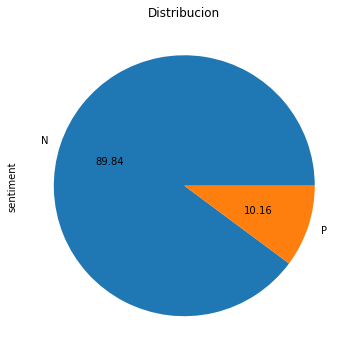

In [57]:
NB_results['sentiment'].value_counts().plot(kind='pie', title="Distribucion", figsize=(6,6),autopct='%.2f')

In [58]:
nb_class.show_most_informative_features(10)

Most Informative Features
            neg_r(felic) = 0.0                 P : N      =     30.5 : 1.0
             has(encant) = 1                   P : N      =     27.5 : 1.0
          has(graci,por) = 1                   P : N      =     27.5 : 1.0
           neg_r(encant) = 0.0                 P : N      =     27.5 : 1.0
           neg_l(encant) = 0.0                 P : N      =     26.5 : 1.0
           has(muy,buen) = 1                   P : N      =     23.5 : 1.0
          has(__HASH_FF) = 1                   P : N      =     20.9 : 1.0
        neg_l(__HASH_FF) = 0.0                 P : N      =     20.9 : 1.0
   emoji_(face-positive) = 'face-positive'      P : N      =     20.7 : 1.0
  has(graci,__PUNC_EXCL) = 1                   P : N      =     20.4 : 1.0


# STOP WORDS

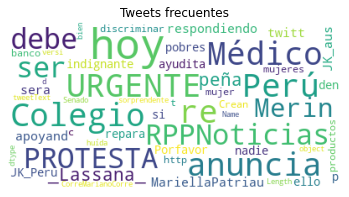

In [59]:

punctuation = list(string.punctuation)
stop = stopwords.words('spanish') + punctuation + ['rt', 'via']
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop,
                          max_words=150,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(processed_tweets['tweetText']))
plt.imshow(wordcloud)
plt.rcParams["figure.figsize"] = (10,10)
plt.axis('off')
plt.title("Tweets frecuentes")
plt.show()